## Pluralsight Takehome - Andrew August

### Goal

Make an accurate binary classifier for real valued inputs. The product will be a model that maps eight floating point numbers to either 0 or 1, and its predictions on a test set. See `recruiting_zeta-disease_take-home-challenge.md` for more details.

### Solution

- Training:
  1. Load the training set
  2. Check for missing data
  3. Plot the distribution of values in each column in order to get a sense of their scale, also check for outliers
  4. Split the training set into train/val and scale them by their mean and variance
  5. Train a Random Forrest model on the scaled set
  6. Print val metrics and the confusion matrix of the model
  7. Verify that the model performs well, then re-train it on the ENTIRE set, not holding out val. This way the model used for testing (the re-trained model) will have seen more training samples before it gets used for testing.
- Testing:
  1. Load the testing set
  2. Do an exploratory analysis as was done for the training set
  3. Predict on testing data with the trained model and save the results to a csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

## Training

### Exploratory Data Analysis

In [2]:
## Load the training set
df = pd.read_csv('data/recruiting_zeta-disease_training-data_take-home-challenge.csv')

First few rows:
   age  weight   bmi  blood_pressure  insulin_test  liver_stress_test  \
0   54     189  27.1              80             0             1.5038   
1   23     150  38.5              68            71             0.3868   
2   47     186  29.9              90             0             0.2728   
3   18     150  30.8              70          1033             0.6598   
4   24     160  32.4              74           125             0.7608   

   cardio_stress_test  years_smoking  zeta_disease  
0                   0             10             0  
1                  55              2             0  
2                   0              7             0  
3                  56              0             0  
4                  59              2             0  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age  

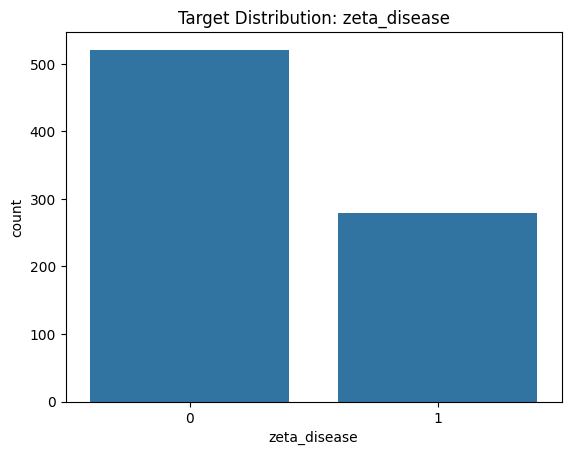

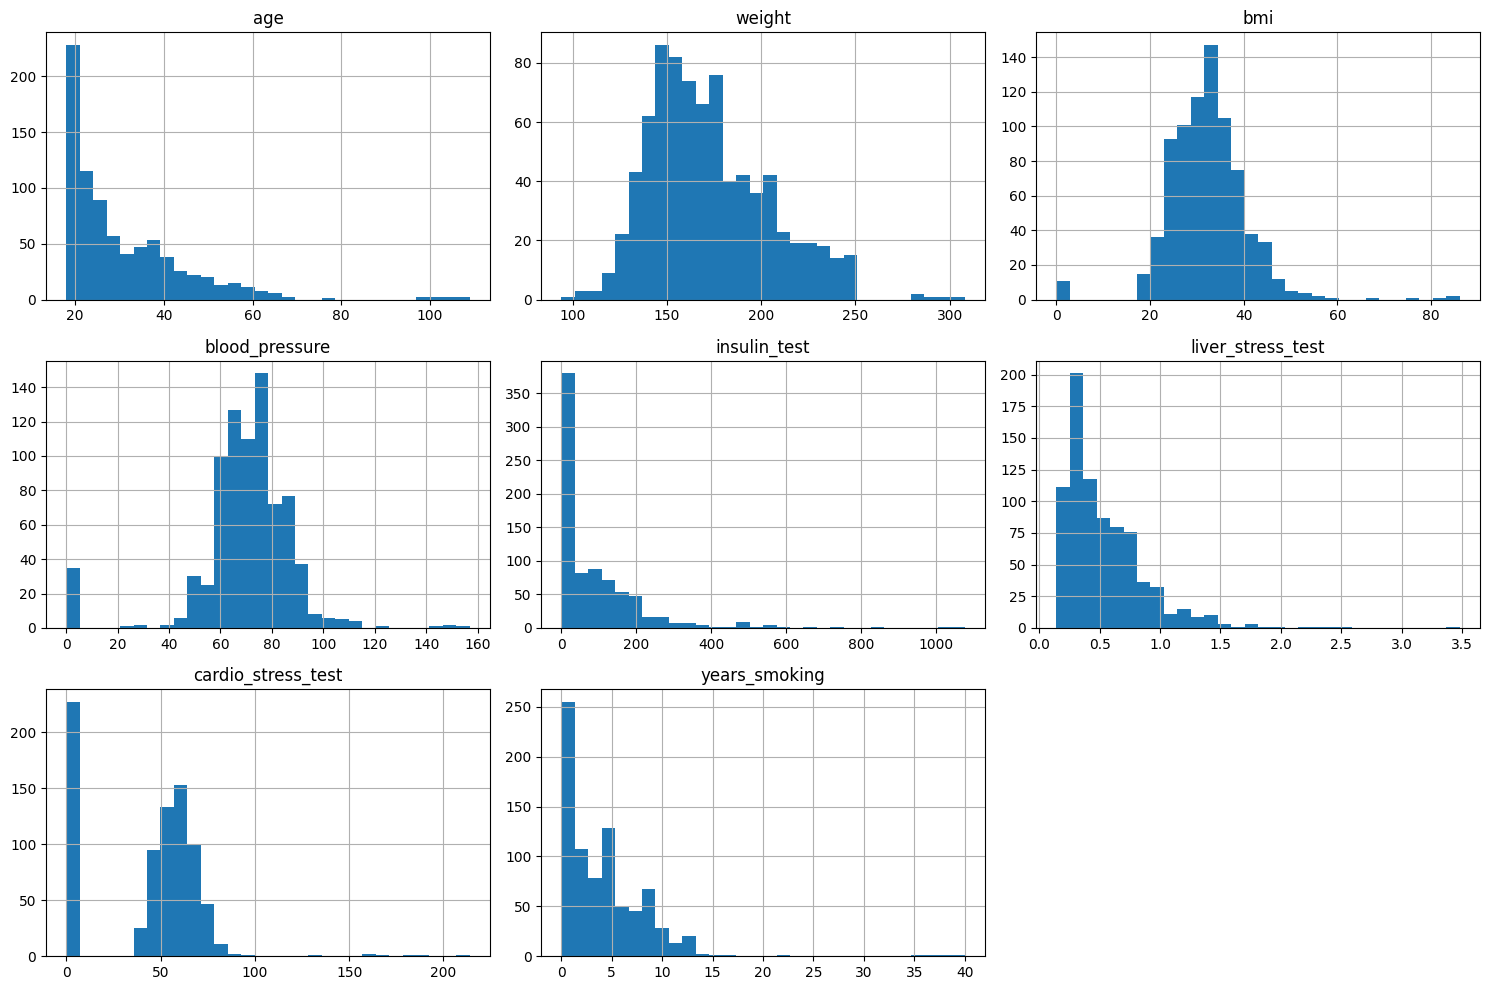

In [3]:
## EDA
print("First few rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nTarget distribution:")
print(df['zeta_disease'].value_counts())

# Plot target distribution
sns.countplot(data=df, x='zeta_disease')
plt.title('Target Distribution: zeta_disease')
plt.show()

# Plot feature distributions for numerical columns
numeric_cols = df.select_dtypes(include=np.number).columns.drop('zeta_disease', errors='ignore')
df[numeric_cols].hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

### Preprocessing and Random Forrest Training

In [4]:
## Data Preprocessing
X = df.drop(columns=['zeta_disease'])
y = df['zeta_disease']

# Handle categorical features if any
X = pd.get_dummies(X)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [5]:
## Train a random forrest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False



Classification Report - Random Forrest:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       109
           1       0.65      0.59      0.62        51

    accuracy                           0.77       160
   macro avg       0.73      0.72      0.73       160
weighted avg       0.76      0.77      0.77       160



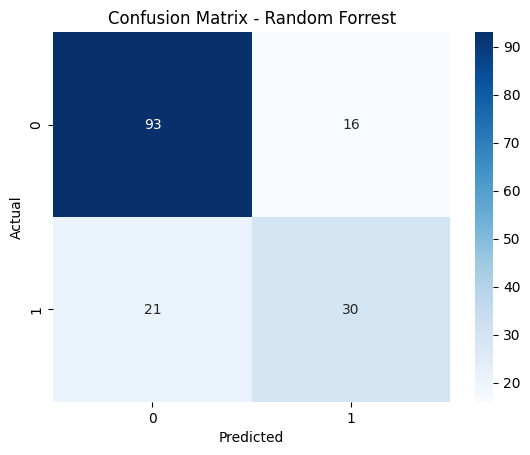

In [6]:
## Evaluate the model
y_pred = random_forest_model.predict(X_val)
print("\nClassification Report - Random Forrest:")
print(classification_report(y_val, y_pred))

sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forrest")
plt.show()

In [7]:
## Retrain the model on the full labelled set
# Scale
deployment_scaler = StandardScaler()
X_scaled = deployment_scaler.fit_transform(X)

# Train the model
random_forest_model_deployment = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model_deployment.fit(X_scaled, y)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Testing

### Exploratory Data Analysis

In [8]:
## Load the testing set
df_test = pd.read_csv('data/recruiting_zeta-disease_prediction-data_take-home-challenge.csv')

First few rows:
   age  weight   bmi  blood_pressure  insulin_test  liver_stress_test  \
0   24     151  39.5              69            72             1.3968   
1   27     179  35.5              89           156             1.6608   
2   34     147  26.9              76            74             1.6958   
3   35     206  32.4              73           127             1.4608   
4   60     193  29.8              62           192             1.7798   

   cardio_stress_test  years_smoking  zeta_disease  
0                  56              4           NaN  
1                  43              6           NaN  
2                  53              2           NaN  
3                  61              6           NaN  
4                  65              9           NaN  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age    

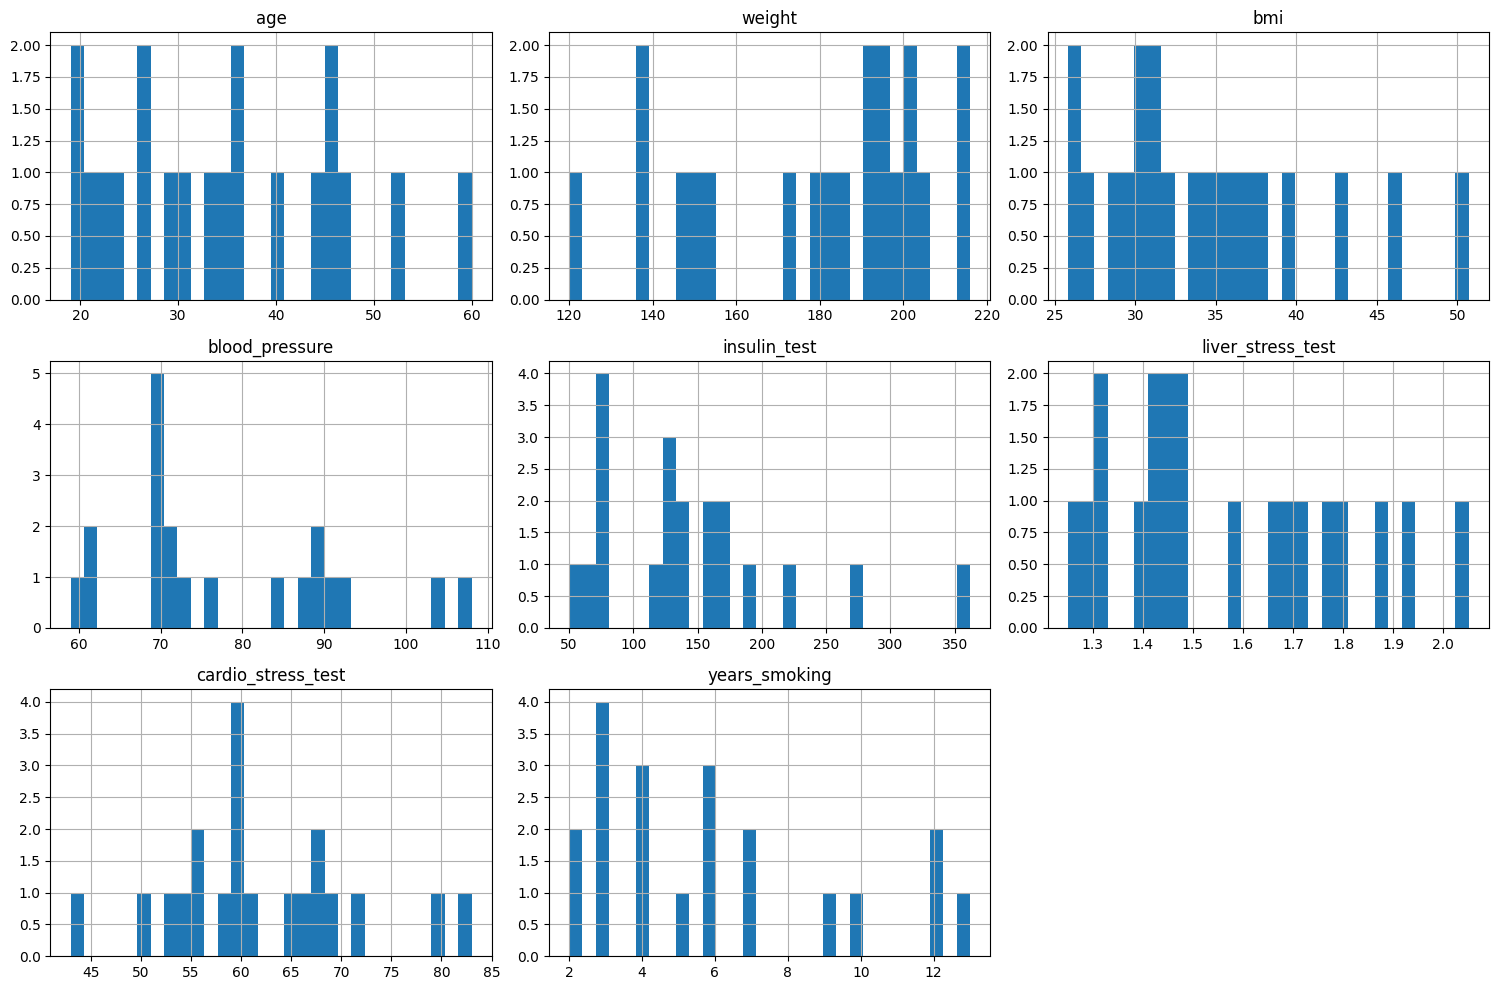

In [9]:
## EDA
print("First few rows:")
print(df_test.head())

print("\nDataset info:")
print(df_test.info())

print("\nMissing values per column:")
print(df_test.isnull().sum())

# Plot feature distributions for numerical columns
numeric_cols = df_test.select_dtypes(include=np.number).columns.drop('zeta_disease', errors='ignore')
df_test[numeric_cols].hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()


### Predictions

In [10]:
# Preprocessing
X_test = df_test.drop(columns=['zeta_disease'])
X_test_scaled = deployment_scaler.transform(X_test)

In [11]:
# Prediction
y_pred_test = random_forest_model_deployment.predict(X_test_scaled)


In [12]:
y_pred_test

array([0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1])

### Save Output

In [13]:
# Add predictions to dataframe and write csv
df_test["zeta_disease"] = y_pred_test
df_test.to_csv("predictions.csv", index=False)